In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('churn_prediction.csv')
df.head()

,customer_id,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,days_since_last_transaction,...,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn
0,1,3135,66,Male,0.0,self_employed,187.0,2,755,224.0,...,1458.71,1458.71,1449.07,0.20,0.20,0.20,0.20,1458.71,1458.71,0
1,2,310,35,Male,0.0,self_employed,NaN,2,3214,60.0,...,8704.66,7799.26,12419.41,0.56,0.56,5486.27,100.56,6496.78,8787.61,0
2,4,2356,31,Male,0.0,salaried,146.0,2,41,NaN,...,5815.29,4910.17,2815.94,0.61,0.61,6046.73,259.23,5006.28,5070.14,0
3,5,478,90,NaN,NaN,self_employed,1020.0,2,582,147.0,...,2291.91,2084.54,1006.54,0.47,0.47,0.47,2143.33,2291.91,1669.79,1
4,6,2531,42,Male,2.0,self_employed,1494.0,3,388,58.0,...,1401.72,1643.31,1871.12,0.33,714.61,588.62,1538.06,1157.15,1677.16,1


In [3]:
df.isnull().sum()

customer_id                          0
vintage                              0
age                                  0
gender                             525
dependents                        2463
occupation                          80
city                               803
customer_nw_category                 0
branch_code                          0
days_since_last_transaction       3223
current_balance                      0
previous_month_end_balance           0
average_monthly_balance_prevQ        0
average_monthly_balance_prevQ2       0
current_month_credit                 0
previous_month_credit                0
current_month_debit                  0
previous_month_debit                 0
current_month_balance                0
previous_month_balance               0
churn                                0
dtype: int64

In [7]:
df['gender'].replace({'Male': 1, 'Female': 0}, inplace = True)
df['gender'] = df['gender'].fillna(-1)

In [10]:
df['occupation'].value_counts()

self_employed    17476
salaried          6704
student           2058
retired           2024
company             40
Name: occupation, dtype: int64

In [11]:
df['city'].value_counts()

1020.0    3479
1096.0    2016
409.0     1334
146.0     1291
834.0     1138
          ... 
748.0        1
1099.0       1
108.0        1
655.0        1
723.0        1
Name: city, Length: 1604, dtype: int64

In [12]:
df['dependents'] = df['dependents'].fillna(0)
df['occupation'] = df['occupation'].fillna('self_employed')
df['city'] = df['city'].fillna(1020)
df['days_since_last_transaction'] = df['days_since_last_transaction'].fillna(999)

In [14]:
df = pd.get_dummies(df)

In [20]:
num_cols = ['current_balance', 'previous_month_end_balance',
       'average_monthly_balance_prevQ', 'average_monthly_balance_prevQ2',
       'current_month_credit', 'previous_month_credit', 'current_month_debit',
       'previous_month_debit', 'current_month_balance',
       'previous_month_balance']

for i in num_cols:
    df[i] = np.log(df[i] + 17000)
    
scaler = StandardScaler()
scaled = scaler.fit_transform(df[num_cols])
scaled = pd.DataFrame(scaled, columns = num_cols)

In [24]:
df_df_og = df.copy()

In [25]:
df = df.drop(columns = num_cols, axis = 1)
df = df.merge(scaled, left_index = True, right_index = True, how = 'left')

In [30]:
y_all = df['churn']
df = df.drop(columns = ['churn', 'customer_id'], axis = 1)

In [32]:
baseline_cols = ['current_month_debit', 'previous_month_debit','current_balance','previous_month_end_balance','vintage'
                 ,'occupation_retired', 'occupation_salaried','occupation_self_employed', 'occupation_student']

In [120]:
df_baseline = df[baseline_cols]
df_baseline.head()

,current_month_debit,previous_month_debit,current_balance,previous_month_end_balance,vintage,occupation_retired,occupation_salaried,occupation_self_employed,occupation_student
0,-0.368262,-0.377401,-0.613754,-0.632384,3135,0,0,1,0
1,0.641022,-0.355686,0.011276,0.446481,310,0,0,1,0
2,0.729864,-0.321614,-0.209650,0.057986,2356,0,1,0,0
3,-0.368204,0.060603,-0.470845,-0.488541,478,0,0,1,0
4,-0.245467,-0.057921,-0.708234,-0.642459,2531,0,0,1,0


In [34]:
train_x, test_x, train_y, test_y = train_test_split(df_baseline, y_all, test_size = 1/3, random_state = 2134, stratify = y_all)

In [39]:
model = LogReg()
model.fit(train_x, train_y)

pred = model.predict_proba(test_x)[:, 1]

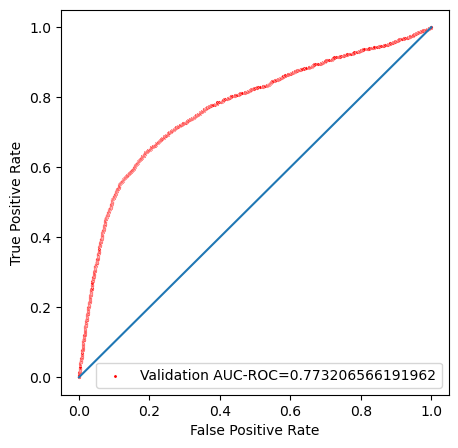

In [55]:
fpr, tpr, _ = roc_curve(test_y, pred)
roc = roc_auc_score(test_y, pred)
plt.figure(figsize = (5,5))
sns.scatterplot(x = fpr, y = tpr, label="Validation AUC-ROC="+str(roc), s=5, color = 'Red')
a = np.linspace(0, 1)
plt.plot(a, a)
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.legend(loc=4) 
plt.show()

In [56]:
pred_val = model.predict(test_x)
cm = confusion_matrix(test_y, pred_val)
cm

array([[7620,   88],
       [1578,  175]], dtype=int64)

In [57]:
recall_score(pred_val, test_y)

0.6653992395437263

In [91]:
def cv_score (ml_model, rstate = 12, thres = 0.5, cols= df.columns):
    i = 1
    cv_scores = []
    df1 = df[cols]
    
    # 5 Fold cross validation stratified on the basis of target
    kf = StratifiedKFold(n_splits = 5, random_state = rstate, shuffle = True)
    for df_index, test_index in kf.split(df1, y_all):
        print('\n{} of KFold {}'.format(i, kf.n_splits))
        xtr, xval = df1.loc[df_index], df1.loc[test_index]
        ytr, yval = y_all.loc[df_index], y_all.loc[test_index]
        
        # Defining model for fitting on training set for each fold
        model = ml_model
        model.fit(xtr, ytr)
        pred_prob = model.predict_proba(xval)
        pred_val = []
              
        
        for j in pred_prob[:,1]:
              if j > thres:
                  pred_val.append(1)
              else:
                  pred_val.append(0)
        
        #Calculate and print scores for each fold
        roc_score = roc_auc_score(yval, pred_prob[:,1])
        recall = recall_score(yval, pred_val)
        precision = precision_score(yval, pred_val)
        print('ROC AUC Score: {}, Recall Score: {}, Precision Score: {}'.format(roc_score, recall, precision))
        
        cv_scores.append(roc_score)
        i+=1
    return cv_scores

In [92]:
baseline_scores = cv_score(LogReg(), cols = baseline_cols)


1 of KFold 5
ROC AUC Score: 0.7659568389682458, Recall Score: 0.07984790874524715, Precision Score: 0.6176470588235294

2 of KFold 5
ROC AUC Score: 0.7807320933100401, Recall Score: 0.12832699619771862, Precision Score: 0.6852791878172588

3 of KFold 5
ROC AUC Score: 0.7552859029431499, Recall Score: 0.13498098859315588, Precision Score: 0.6425339366515838

4 of KFold 5
ROC AUC Score: 0.7594824736537424, Recall Score: 0.12357414448669202, Precision Score: 0.6565656565656566

5 of KFold 5
ROC AUC Score: 0.7621752766192588, Recall Score: 0.1112167300380228, Precision Score: 0.582089552238806


In [93]:
all_feature_score = cv_score(LogReg(), cols = df.columns)


1 of KFold 5
ROC AUC Score: 0.7736456684821704, Recall Score: 0.1720532319391635, Precision Score: 0.6654411764705882

2 of KFold 5
ROC AUC Score: 0.7713016134004728, Recall Score: 0.14923954372623574, Precision Score: 0.6826086956521739

3 of KFold 5
ROC AUC Score: 0.7379887707711131, Recall Score: 0.12452471482889733, Precision Score: 0.5622317596566524

4 of KFold 5
ROC AUC Score: 0.7465459595826699, Recall Score: 0.11406844106463879, Precision Score: 0.5797101449275363

5 of KFold 5
ROC AUC Score: 0.724287524504322, Recall Score: 0.09695817490494296, Precision Score: 0.5125628140703518


In [94]:
from sklearn.feature_selection import RFE

model = LogReg()
rfe = RFE(estimator = model, n_features_to_select = 1, step = 1)
rfe.fit(df, y_all)

RFE(estimator=LogisticRegression(), n_features_to_select=1)

In [95]:
ranking_df = pd.DataFrame()
ranking_df['Feature'] = df.columns
ranking_df['Rank'] = rfe.ranking_

In [96]:
ranked = ranking_df.sort_values(by = 'Rank')
ranked

,Feature,Rank
13,current_balance,1
15,average_monthly_balance_prevQ,2
8,occupation_company,3
16,average_monthly_balance_prevQ2,4
21,current_month_balance,5
22,previous_month_balance,6
19,current_month_debit,7
9,occupation_retired,8
5,customer_nw_category,9
20,previous_month_debit,10


In [97]:
top_10_scores = cv_score(LogReg(), cols = ranked['Feature'][:10].values)


1 of KFold 5
ROC AUC Score: 0.7982897954989209, Recall Score: 0.24049429657794677, Precision Score: 0.7354651162790697

2 of KFold 5
ROC AUC Score: 0.8033295653067516, Recall Score: 0.2252851711026616, Precision Score: 0.7547770700636943

3 of KFold 5
ROC AUC Score: 0.7991755693554541, Recall Score: 0.22813688212927757, Precision Score: 0.7250755287009063

4 of KFold 5
ROC AUC Score: 0.795978906548081, Recall Score: 0.21292775665399238, Precision Score: 0.7320261437908496

5 of KFold 5
ROC AUC Score: 0.7944607486810424, Recall Score: 0.19391634980988592, Precision Score: 0.6754966887417219


In [98]:
cv_score(LogReg(), cols = ranked['Feature'][:10].values, thres = 0.14)


1 of KFold 5
ROC AUC Score: 0.7982897954989209, Recall Score: 0.8298479087452472, Precision Score: 0.2890728476821192

2 of KFold 5
ROC AUC Score: 0.8033295653067516, Recall Score: 0.8231939163498099, Precision Score: 0.2946580469547465

3 of KFold 5
ROC AUC Score: 0.7991755693554541, Recall Score: 0.8184410646387833, Precision Score: 0.29547014413177763

4 of KFold 5
ROC AUC Score: 0.795978906548081, Recall Score: 0.8127376425855514, Precision Score: 0.2923076923076923

5 of KFold 5
ROC AUC Score: 0.7944607486810424, Recall Score: 0.814638783269962, Precision Score: 0.3032554847841472


[0.7982897954989209,
 0.8033295653067516,
 0.7991755693554541,
 0.795978906548081,
 0.7944607486810424]

In [100]:
roc_table = pd.DataFrame({'Baseline': baseline_scores, 'All Features': all_feature_score, 'Top 10': top_10_scores})
roc_table

,Baseline,All Features,Top 10
0,0.765957,0.773646,0.798290
1,0.780732,0.771302,0.803330
2,0.755286,0.737989,0.799176
3,0.759482,0.746546,0.795979
4,0.762175,0.724288,0.794461


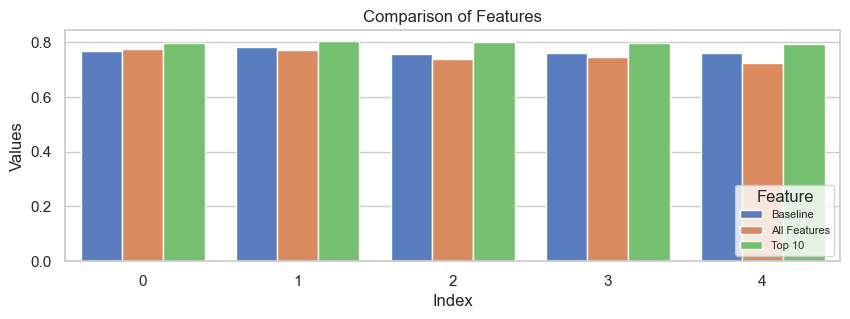

In [119]:
roc_table_melted = roc_table.reset_index().melt(id_vars='index', var_name='Feature', value_name='Value')

# Set the style for the plot
sns.set(style='whitegrid')

# Create the bar plot
plt.figure(figsize=(10, 3), dpi = 100)
sns.barplot(data=roc_table_melted, x='index', y='Value', hue='Feature', palette='muted')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Comparison of Features')
plt.legend(title='Feature', loc='lower right', fontsize = 8)
plt.show()